In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import time

from gpcsd.gpcsd1d import GPCSD1D
from gpcsd import forward_models, predict_csd
from gpcsd.utility_functions import normalize
from kcsd import KCSD1D
from forward_models import fwd_model_1d, b_fwd_1d
import utility_functions as utils
import rCSD

np.random.seed(0)
utils.use_pdf_plot()

# Two dipoles

generated CSD of shape
(231, 50)


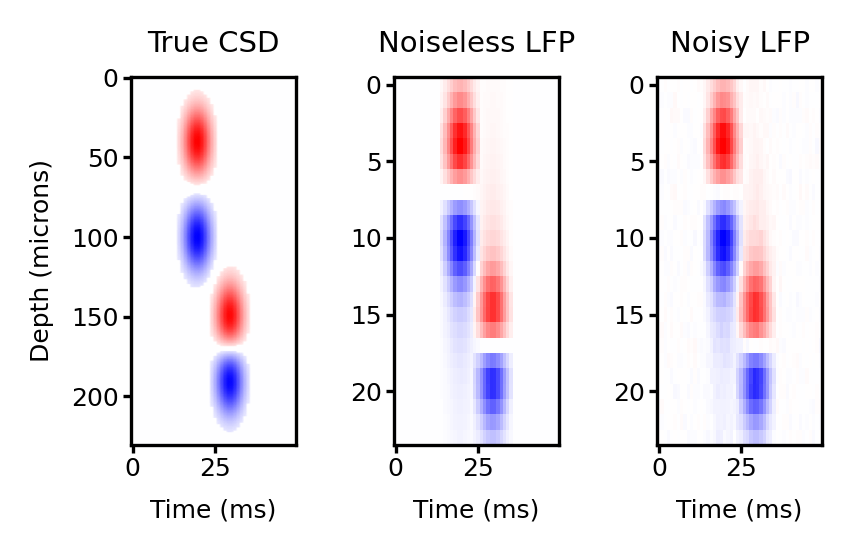

In [54]:
"""
 Simulate some data with a simple template CSD (dipole-like with one spatial dimension), 
 compare GPCSD to traditional CSD and kCSD estimation with and without noise.
 Produces Figure 1 in the paper.
"""

# %% Functions for CSD pattern and normalization
def csd_true_f(x, t):
    """
    Calculates a toy CSD mean function with two dipoles.
    :param x: desired spatial coordinates (between 0 and 24)
    :param t: desired time coordinates in milliseconds
    :return: (nx, nt) array of values
    """
    # comp1 = np.clip(150 - np.abs(x-200), 0, None) * np.clip(5 - np.abs(t.T-20), 0, None)
    # comp2 = - np.clip(150 - np.abs(x-800), 0, None) * np.clip(5 - np.abs(t.T-20), 0, None)
    # comp3 = np.clip(150 - np.abs(x-1600), 0, None) * np.clip(5 - np.abs(t.T-30), 0, None)
    # comp4 = - np.clip(150 - np.abs(x-2200), 0, None) * np.clip(5 - np.abs(t.T-30), 0, None)

    comp1 = np.exp(-(x-400)**2/(2*150**2))*np.exp(-(t.T-20)**2/(2*3**2)) 
    comp2 = -np.exp(-(x-1000)**2/(2*150**2))*np.exp(-(t.T-20)**2/(2*3**2))
    comp3 = np.exp(-(x-1500)**2/(2*150**2))*np.exp(-(t.T-30)**2/(2*3**2)) 
    comp4 = -np.exp(-(x-1900)**2/(2*150**2))*np.exp(-(t.T-30)**2/(2*3**2))
    val = comp1 + comp2 + comp3 + comp4

    val[np.abs(val) < 1e-1] = 0  # Set small values to zero
    return val/np.max(np.abs(val))

# %% Setup 
a = 0          # Top edge of electrode probe (microns)
b = 2300       # Bottom edge of electrode probe (microns)
R_true = 150   # Radius of cylinder in forward model (microns)
deltaz = 10.0   # Spacing for predictions spatially (microns)
nt = 50        # Number of time points
nx = 24        # Number of observed spatial locations for LFP
snr = 30       # noise characteristics

t = np.linspace(0, 50, nt)[:, None]
x = np.linspace(a, b, nx)[:, None]
nz = int(np.rint(b-a)/deltaz) + 1
z = np.linspace(a, b, nz)[:, None]

# %% Create true CSD
csd_true = csd_true_f(z, t)
print('generated CSD of shape')
print(csd_true.shape)

# %% Create observed LFP
noiseless = normalize(forward_models.fwd_model_1d(csd_true, z, x, R_true))

# Add white noise to LFP
lfp = noiseless + np.random.normal(0, 0.01, size=(nx, nt))

plt.figure(figsize=(3, 2), dpi=300)
plt.subplot(131)
plt.imshow(csd_true, aspect='auto', cmap='bwr')
plt.title('True CSD')
plt.ylabel('Depth (microns)')
plt.xlabel('Time (ms)')
plt.subplot(132)
plt.imshow(noiseless, aspect='auto', cmap='bwr')
plt.title('Noiseless LFP')
plt.xlabel('Time (ms)')
plt.subplot(133)
plt.imshow(lfp, aspect='auto', cmap='bwr')
plt.title('Noisy LFP')
plt.xlabel('Time (ms)')

plt.tight_layout()
plt.show()



In [57]:
### tCSD
tcsd = predict_csd.predictcsd_trad_1d(lfp[:, :, None]).squeeze()

### GPCSD
gpcsd = GPCSD1D(lfp, x, t)
# print(gpcsd)
gpcsd.fit(n_restarts=10)
gpcsd.predict(z, t)
# print(gpcsd)

### kCSD
kcsd = KCSD1D(x, lfp, gdx=deltaz, h=R_true)
kcsd.cross_validate(Rs=np.linspace(100, 800, 15), lambdas=np.logspace(4,-15,25,base=10.))
kcsd = kcsd.values()

### rCSD
Y_smo = lfp[:, :, None]
R = R_true
A = b_fwd_1d(z.T-x, R)
lam_smooth = 10
lam_region = 0
lam_lasso = 0.2e-1
intervals = np.array([0, np.nonzero(x > 1000)[0][0],
                      np.nonzero(x > 1500)[0][0], nx])
structure_acronyms = np.array(['Superficial', 'Medium', 'Deep'])
intervals_csd = np.array([0, np.nonzero(z > 1000)[0][0],
                          np.nonzero(z > 1500)[0][0], nz])
csd_lasso = rCSD.region_conservation_multiple_trial(
    Y_smo, A, intervals_csd, lam_smooth, lam_region, lam_lasso
)

Restarts:   0%|          | 0/10 [00:00<?, ?it/s]

Restarts: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


Cross validating R (all lambda) : 100.0
Cross validating R (all lambda) : 150.0
Cross validating R (all lambda) : 200.0
Cross validating R (all lambda) : 250.0
Cross validating R (all lambda) : 300.0
Cross validating R (all lambda) : 350.0
Cross validating R (all lambda) : 400.0
Cross validating R (all lambda) : 450.0
Cross validating R (all lambda) : 500.0
Cross validating R (all lambda) : 550.0
Cross validating R (all lambda) : 600.0
Cross validating R (all lambda) : 650.0
Cross validating R (all lambda) : 700.0
Cross validating R (all lambda) : 750.0
Cross validating R (all lambda) : 800.0
R, lambda : 350.0 1.1006941712522103


In [62]:
A.shape

(24, 231)

In [61]:
layer_intervals = [1000, 1500]
np.array([0, np.nonzero(z > layer_intervals[0])[0][0],
                                          np.nonzero(z > layer_intervals[1])[0][0], nz])

array([  0, 101, 151, 231])

In [83]:
### rCSD
Y_smo = lfp[:, :, None]
R = R_true
A = b_fwd_1d(z.T-x, R)
lam_smooth = 10
lam_region = 0
lam_lasso = 0.2e-1
intervals = np.array([0, np.nonzero(x > 1000)[0][0],
                      np.nonzero(x > 1500)[0][0], nx])
structure_acronyms = np.array(['Superficial', 'Medium', 'Deep'])
intervals_csd = np.array([0, np.nonzero(z > 1000)[0][0],
                          np.nonzero(z > 1500)[0][0], nz])
csd_lasso = rCSD.region_conservation_multiple_trial(
    Y_smo, A, intervals_csd, lam_smooth, lam_region, lam_lasso
)


In [119]:
rcsd = rCSD.rCSD(lfp[:, :, None], z, x, boundary_depth=[1000, 1500], 
                 R=R_true, lam_smooth=lam_smooth, lam_region=lam_region, lam_lasso=lam_lasso)
rcsd_pred = rcsd.predict()
rcsd_pred = rCSD.region_conservation_multiple_trial(
    Y_smo, A, intervals_csd, lam_smooth, lam_region, lam_lasso
)


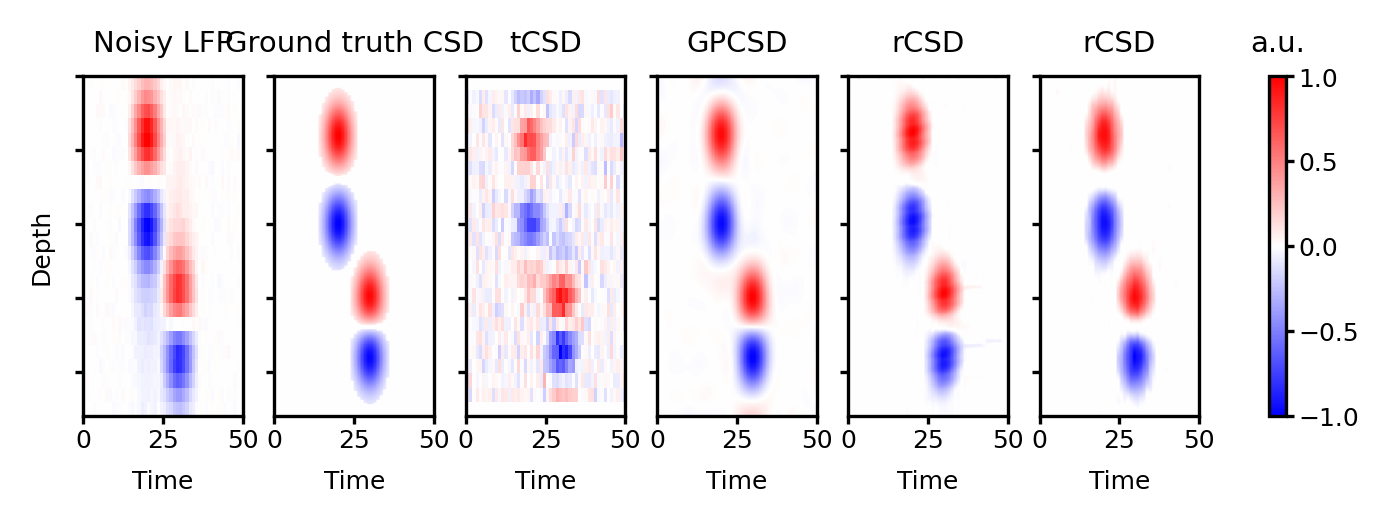

In [120]:
# %% Visualize results
vmlfp = np.amax(np.abs(noiseless))
vmcsd = np.amax(np.abs(normalize(csd_true)))


f = plt.figure(figsize=(6, 1.5), dpi=300)

ax = plt.subplot(161)
plt.subplot(161)
plt.imshow(lfp, aspect='auto', 
           vmin=-vmlfp, vmax=vmlfp, cmap='bwr', extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('Noisy LFP')
plt.ylabel('Depth')
plt.xlabel('Time')
axtmp = plt.subplot(162, sharey = ax)
axtmp.set_yticklabels([])

plt.subplot(162, sharey = ax)
plt.imshow(normalize(csd_true), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap='bwr', extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('Ground truth CSD')
plt.xlabel('Time')

plt.subplot(163, sharey = ax)
plt.imshow(normalize(tcsd), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap='bwr', extent=[t[0, 0], t[-1, 0], x[-1, 0], x[0, 0]])
plt.title('tCSD')
plt.xlabel('Time')

plt.subplot(164, sharey = ax)
plt.imshow(normalize(gpcsd.csd_pred), aspect='auto', 
           vmin=-vmcsd, vmax=vmcsd, cmap='bwr', extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('GPCSD')
plt.xlabel('Time')

# plt.subplot(165, sharey = ax)
# im = plt.imshow(normalize(kcsd), aspect='auto', 
#                 vmin=-vmcsd, vmax=vmcsd, cmap='bwr', extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
# plt.title('kCSD')
# plt.xlabel('Time')

plt.subplot(165, sharey = ax)
im = plt.imshow(normalize(rcsd_pred), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap='bwr', extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('rCSD')
plt.xlabel('Time')

plt.subplot(166, sharey = ax)
im = plt.imshow(normalize(csd_lasso), aspect='auto', 
                vmin=-vmcsd, vmax=vmcsd, cmap='bwr', extent=[t[0, 0], t[-1, 0], z[-1, 0], z[0, 0]])
plt.title('rCSD')
plt.xlabel('Time')


clb = f.colorbar(im, ax=f.axes)
clb.ax.set_title('a.u.')
plt.show()